In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

house-prices-advanced-regression-techniques



In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [5]:
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

print('numerical columns are ', num_cols, '\n\n')
print('categorical columns are ', cat_cols)

numerical columns are  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 


categorical columns are  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fire

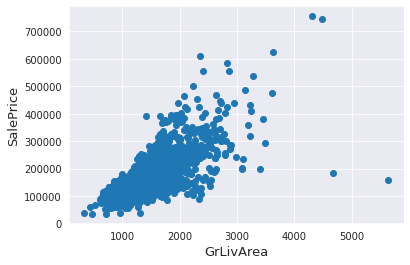

In [6]:
# Showing that the GrLivArea columns has some outliers.
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them.**

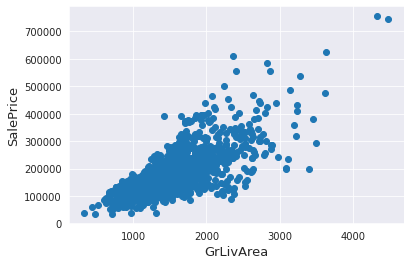

In [7]:
# Dropping those outliers of GrLivArea.
# you can easily see that the region GrLivarea>4000 & SalePrice<30000 represents outliers
# So we need to drop those data away

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [8]:
# The target variable is right skewed. As (linear) models love normally distributed data,
# we need to transform this variable and make it more normally distributed.

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [10]:
# This will give you all columns with missing data and thier ratio
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


# Now it's the time to deal with missing values.

In [11]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

all_data["Alley"] = all_data["Alley"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [12]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [13]:
# labeling columns to some unique values.
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [14]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [15]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [16]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [17]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [18]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0001))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0001, l1_ratio=.9))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [19]:
# models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]

In [20]:
# def rmsle_cv(model):
#     kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
#     rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [21]:
# for classifier in models:
#     score = rmsle_cv(classifier)
#     print("\n{} score: {:.4f} ({:.4f})\n".format(classifier, score.mean(), score.std()))

# Found out that lasso produced the best score

In [22]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [23]:
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [24]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.26712e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.29086e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.60203e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.19457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning

Stacking Averaged models score: 0.1100 (0.0079)


In [25]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [26]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.36884e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.21307e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.60038e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.17129e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning

0.06978863146406147


In [27]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[17:07:47] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.08729972297639721


In [28]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.10471415799571908


In [29]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07501153181167211


In [30]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [31]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)